In [4]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:0000:0100:01


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [6]:
df = pd.read_csv("/Users/zhangyuxuan/Desktop/mergedata_spam_sms.csv")
df["Label"] = df["Label"].map({"SPAM": 0, "HAM": 1})

X = df["Message"]   
y = df["Label"]      

# TF-IDF 
#   - stop_words="english" eg: "the", "and" 
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# define and train XGBoost classifier
#   - eval_metric='mlogloss' 
#   - use_label_encoder=False avoid warning of label encoder 
model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
# (precision, recall, f1-score)
print(classification_report(y_test, y_pred, target_names=["SPAM", "HAM"]))


/Users/zhangyuxuan/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 89.74%
              precision    recall  f1-score   support

        SPAM       0.90      0.73      0.81       631
         HAM       0.90      0.97      0.93      1532

    accuracy                           0.90      2163
   macro avg       0.90      0.85      0.87      2163
weighted avg       0.90      0.90      0.89      2163



In [12]:
df = pd.read_csv("/Users/zhangyuxuan/Desktop/mergedata_spam_sms.csv")

df["Label"] = df["Label"].map({"SPAM": 0, "HAM": 1})

X = df["Message"]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# create Pipeline
#    (1) TF-IDF symbol extract
#    (2) XGBoost classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', xgb.XGBClassifier(
        eval_metric='mlogloss' 
    ))
])

param_grid = {
    # TF-IDF 
    'tfidf__ngram_range': [(1,1), (1,2)],  
    'tfidf__max_features': [3000, 5000],   
    'tfidf__min_df': [1, 2],              
    'tfidf__max_df': [0.8, 0.9],          
    
    # XGBoost 
    'xgb__n_estimators': [100, 200],       
    'xgb__max_depth': [4, 6],              
    'xgb__learning_rate': [0.1, 0.3],     
    'xgb__subsample': [0.8, 1.0],          
    'xgb__colsample_bytree': [0.8, 1.0],   
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',      
    cv=3,                    
    n_jobs=-1,               
    verbose=2                # 显示详细搜索过程
)

grid_search.fit(X_train, y_train)

# best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# using the best model to prodict 
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["SPAM", "HAM"]))


Fitting 3 folds for each of 512 candidates, totalling 1536 fits
[CV] END tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.1s
[CV] END tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.9s
[CV] END tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.2s
[CV] END tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__min_df=1, tfidf__ngram_range=(1, 1), xgb__colsample_bytree=0.8, xgb__learning_rate=0.3, xgb__max_depth=4, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.6s
[CV] END tfidf__max_

In [8]:
# final model according to the Best Parameters last step
# Best Parameters: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1),
# 'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 6, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("/Users/zhangyuxuan/Desktop/mergedata_spam_sms.csv")
df["Label"] = df["Label"].map({"SPAM": 0, "HAM": 1})

X = df["Message"]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        min_df=2,
        max_features=3000,
        ngram_range=(1,1)
    )),
    ('xgb', xgb.XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.3,
        max_depth=6,
        n_estimators=200,
        subsample=1.0,
        eval_metric='mlogloss'
    ))
])


final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["SPAM", "HAM"]))


Test Accuracy: 92.28%
              precision    recall  f1-score   support

        SPAM       0.90      0.83      0.86       631
         HAM       0.93      0.96      0.95      1532

    accuracy                           0.92      2163
   macro avg       0.92      0.89      0.90      2163
weighted avg       0.92      0.92      0.92      2163



In [6]:
!pip install memory_profiler

In [8]:
%load_ext memory_profiler
%memit final_model.predict(["Try out today the LOVE METER to calculate whether you two are the perfect match! Send your name + your partner name to 33550. N50 Ex: Bello + Passion"])

peak memory: 140.23 MiB, increment: 8.53 MiB


In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

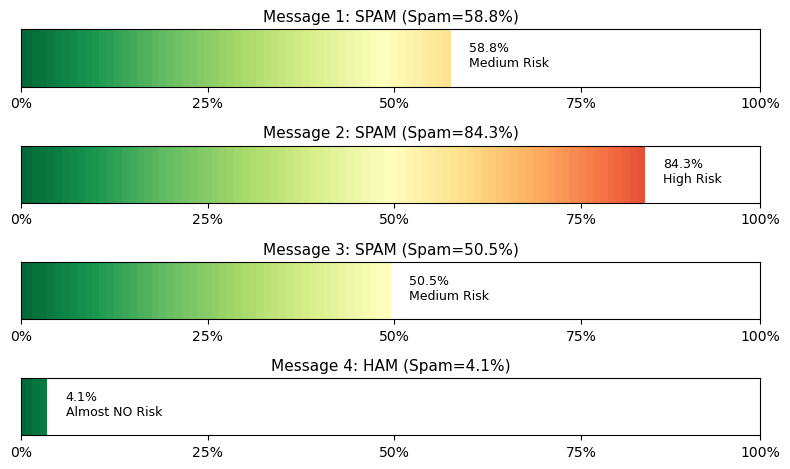

Message 1 => Predicted: SPAM, SPAM Probability: 58.8%
Message 2 => Predicted: SPAM, SPAM Probability: 84.3%
Message 3 => Predicted: SPAM, SPAM Probability: 50.5%
Message 4 => Predicted: HAM, SPAM Probability: 4.1%


In [52]:
new_sms = [
    "Hi, this is Alex from the delivery department. We tried to deliver your package today, but no one was home. Please reply with your full name and address so we can reschedule the delivery.",
    "Congrats! You've won a free data plan. Click to claim now!",
    "URGENT: Your bank account is locked. Please verify immediately.",
    "Happy birthday! Hope you have a wonderful celebration.",
]

# 1) Batch predict probabilities & labels
probs = final_model.predict_proba(new_sms)  # shape: (n_samples, 2)
labels = final_model.predict(new_sms)       # shape: (n_samples,)

# 2) Prepare to plot multiple subplots (one for each message)
n = len(new_sms)
fig, axes = plt.subplots(nrows=n, figsize=(8, 1.2*n))

# If there's only 1 message, axes won't be a list, so make it a list for consistency
if n == 1:
    axes = [axes]

# We'll reuse the same colormap for all bars.
cmap = plt.colormaps.get_cmap("RdYlGn_r").copy()
cmap.set_bad(color='white')  # So NaN appears white

# We define the function that draws one partial gradient bar
def plot_partial_gradient(ax, spam_prob):
    """
    Draw a partial gradient bar on a given Axes 'ax' from 0% to spam_prob*100%,
    then white from spam_prob*100% to 100%.
    """
    height, width = 10, 100
    data = np.zeros((height, width), dtype=float)
    cut = int(spam_prob * width)  # how many columns to fill

    if cut > 0:
        # Create a gradient from 0.0 to spam_prob
        gradient_line = np.linspace(0.0, spam_prob, cut, endpoint=True)
        gradient_2d   = np.tile(gradient_line, (height, 1))
        data[:, :cut] = gradient_2d

    # Fill the remaining columns with NaN
    data[:, cut:] = np.nan

    ax.imshow(
        data,
        cmap=cmap,
        origin='lower',
        aspect='auto',
        vmin=0.0,  # color scale: 0.0 (green) -> 1.0 (red)
        vmax=1.0
    )

    # X-axis from 0..100
    ax.set_xlim(0, width - 1)
    ax.set_xticks([0, 25, 50, 75, 99])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_yticks([])

def get_risk_level(spam_prob):
    """
    Returns a custom text label for spam probability thresholds.
    Adjust as you wish.
    """
    if spam_prob >= 0.75:
        return "High Risk"
    elif spam_prob >= 0.5:
        return "Medium Risk"
    elif spam_prob >= 0.25:    
        return "Risk Controlled"
    else:
        return "Almost NO Risk"

# 3) Loop over each message, draw a row in our figure
for i, msg in enumerate(new_sms):
    # Current Axes
    ax = axes[i]

    # spam_prob is the probability of class 0 = SPAM
    spam_prob = probs[i][0]  
    ham_prob  = probs[i][1]
    pred_label = labels[i]   # 0=SPAM, 1=HAM
    label_str  = "SPAM" if pred_label == 0 else "HAM"

    # Plot partial gradient
    plot_partial_gradient(ax, spam_prob)

    # Show a title or label above it
    ax.set_title(f"Message {i+1}: {label_str} (Spam={spam_prob*100:.1f}%)", fontsize=11)

    # Annotate the risk level on the bar
    risk_level = get_risk_level(spam_prob)
    cut = int(spam_prob * 100)
    ax.text(
        x=cut + 2,
        y=5,  # halfway in height=10
        s=f"{spam_prob*100:.1f}%\n{risk_level}",
        ha="left",
        va="center",
        fontsize=9
    )

# 4) Layout and show
plt.tight_layout()
plt.show()

# 5) Print the final classification results in text (optional)
for i, msg in enumerate(new_sms):
    spam_prob = probs[i][0]
    label_str = "SPAM" if labels[i] == 0 else "HAM"
    print(f"Message {i+1} => Predicted: {label_str}, SPAM Probability: {spam_prob*100:.1f}%")
